In [45]:
# !pip install torch torchvision torchmetrics pycocotools

In [46]:
# !pip install faster-coco-eval

In [3]:
import os
import xml.etree.ElementTree as ET
import shutil
import glob
import random
from sklearn.model_selection import train_test_split
import pandas as pd


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py:11: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.22.4)
  from scipy.sparse import csr_matrix, issparse


In [4]:
# Directories
# TODO : make a validation set here as well

# unzip downloaded data from kaggle link into fruit_dataset folder
# train_dir = r'C:\Users\praka\Acads\M_Tech\bits\Sem 3\CV\asmt_labs\asmt2\fruit_dataset\train_zip\train'
# test_dir = r'C:\Users\praka\Acads\M_Tech\bits\Sem 3\CV\asmt_labs\asmt2\fruit_dataset\test_zip\test'

train_dir = '/home/ec2-user/SageMaker/codes/train_zip/train/'
test_dir = '/home/ec2-user/SageMaker/codes/test_zip/test/'


In [5]:
def extract_annotations(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    boxes = []
    filename = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)

    for obj in root.findall('object'):
        label = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        boxes.append([filename, width, height, label, xmin, ymin, xmax, ymax])

    return boxes

# Function to read all annotations from a directory
def parse_annotations_from_directory(directory):
    annotations = []
    for file in os.listdir(directory):
        if file.endswith(".xml"):
            xml_file = os.path.join(directory, file)
            annotations.extend(extract_annotations(xml_file))
    return annotations

train_annotations = parse_annotations_from_directory(train_dir)
test_annotations = parse_annotations_from_directory(test_dir)

# Convert to pandas DataFrame for easy manipulation
columns = ['filename', 'width', 'height', 'label', 'xmin', 'ymin', 'xmax', 'ymax']
full_train_df = pd.DataFrame(train_annotations, columns=columns)
test_df = pd.DataFrame(test_annotations, columns=columns)

In [6]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(full_train_df, test_size=0.2, random_state=42)

In [7]:
train_df.shape, val_df.shape, test_df.shape

((372, 8), (93, 8), (117, 8))

In [8]:
# train_df = train_df.tail(20)  # temp
# train_df = train_df.tail(10)  # temp
# train_df = train_df.tail(15)  # temp
# train_df.shape, val_df.shape, test_df.shape

In [9]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = fasterrcnn_resnet50_fpn(pretrained=True, weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
model.to(device)

cuda


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [10]:
num_classes = 5  # Assuming background + 1 fruit class (apple, banana, orange, mixed)
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = torch.nn.Linear(in_features, num_classes)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [11]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

class FruitDataset(Dataset):
    def __init__(self, df, img_dir, transforms=None):
        self.df = df
        self.img_dir = img_dir
        self.transforms = transforms
        # Create a mapping of class names to integers
        self.class_to_index = {'apple': 1, 'banana': 2, 'orange': 3, 'mixed': 4}

    def __getitem__(self, idx):
        # Get the image file
        img_name = self.df.iloc[idx]['filename']
        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        # Get bounding boxes
        xmin = self.df.iloc[idx]['xmin']
        ymin = self.df.iloc[idx]['ymin']
        xmax = self.df.iloc[idx]['xmax']
        ymax = self.df.iloc[idx]['ymax']
        boxes = [[xmin, ymin, xmax, ymax]]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # Get labels
        class_name = self.df.iloc[idx]['label']  # 'label' column contains the fruit names
        label = self.class_to_index.get(class_name, 0)  # Default to 0 if class_name not found
        labels = torch.as_tensor([label], dtype=torch.int64)

        # Create target dict
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        # Apply transformations
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.df)

# Image transformations
transforms = T.Compose([
    T.ToTensor()
])

# Initialize Dataset and DataLoader
batch_size = 10
train_dataset = FruitDataset(train_df, train_dir, transforms=transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

In [15]:
%%time
import torch.optim as optim

learning_rate = 0.005
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)
num_epochs = 30
loss_values = []

# Training loop
for epoch in range(num_epochs):
    model.to(device)
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for i, (images, targets) in enumerate(train_loader):
        # shifting to gpu if available
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # Zero gradients from previous steps
        optimizer.zero_grad()

        # Forward pass to get the loss
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        # Backward pass to calculate gradients
        losses.backward()

        # Optimize
        optimizer.step()

        # Accumulate loss for visualization
        running_loss += losses.item()
    # Average loss over an epoch
    avg_loss = running_loss / len(train_loader)
    loss_values.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/30], Loss: 0.2588
Epoch [2/30], Loss: 0.1778
Epoch [3/30], Loss: 0.1451
Epoch [4/30], Loss: 0.1290
Epoch [5/30], Loss: 0.1183
Epoch [6/30], Loss: 0.1098
Epoch [7/30], Loss: 0.1054
Epoch [8/30], Loss: 0.0995
Epoch [9/30], Loss: 0.0928
Epoch [10/30], Loss: 0.0896
Epoch [11/30], Loss: 0.0870
Epoch [12/30], Loss: 0.0857
Epoch [13/30], Loss: 0.0805
Epoch [14/30], Loss: 0.0769
Epoch [15/30], Loss: 0.0768
Epoch [16/30], Loss: 0.0780
Epoch [17/30], Loss: 0.0740
Epoch [18/30], Loss: 0.0711
Epoch [19/30], Loss: 0.0693
Epoch [20/30], Loss: 0.0677
Epoch [21/30], Loss: 0.0668
Epoch [22/30], Loss: 0.0655
Epoch [23/30], Loss: 0.0652
Epoch [24/30], Loss: 0.0642
Epoch [25/30], Loss: 0.0651
Epoch [26/30], Loss: 0.0633
Epoch [27/30], Loss: 0.0622
Epoch [28/30], Loss: 0.0618
Epoch [29/30], Loss: 0.0602
Epoch [30/30], Loss: 0.0594
CPU times: user 1h 29min 20s, sys: 5min 29s, total: 1h 34min 49s
Wall time: 20min 11s


In [16]:
torch.save(model.state_dict(), "fasterrcnn_fruit_detection_v2.pth")

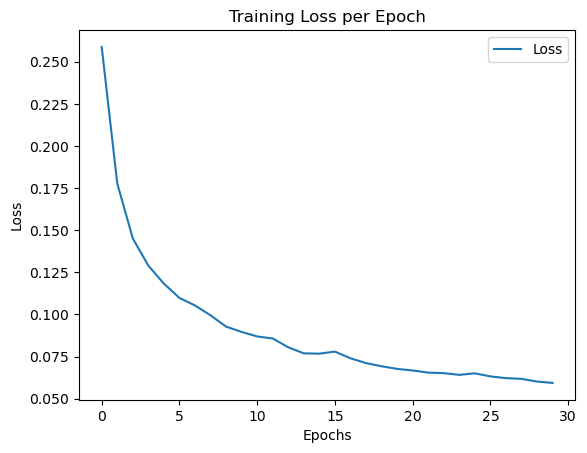

In [17]:
import matplotlib.pyplot as plt
# Visualizing the loss trend over epochs
plt.plot(range(num_epochs), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.show()

In [18]:
# Create validation and test datasets using the same FruitDataset class
val_dataset = FruitDataset(val_df, train_dir, transforms=transforms)
test_dataset = FruitDataset(test_df, test_dir, transforms=transforms)

# Create DataLoader for validation and test datasets
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

(10, 12)

In [44]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from sklearn.metrics import precision_score, recall_score

metric = MeanAveragePrecision()

# Containers for true and predicted labels across all batches
all_true_labels = []
all_pred_labels = []


# Evaluate model on validation set
model.eval()  # Set model to evaluation mode

for img, tar in val_loader:
    with torch.no_grad():
        # Move img and tar to GPU
        img = [image.to(device) for image in img]
        tar = [{k: v.to(device) for k, v in t.items()} for t in tar]

        # Get model predictions
        preds = model(img)
        # Extract predicted and true labels
        for i in range(len(tar)):
            output = preds[i]
            true_labels = tar[i]['labels'].cpu().numpy()  # Move to CPU for numpy
            pred_labels = preds[i]['labels'].cpu().numpy()[:1]  # Move to CPU for numpy
            # Append to the full list of true and predicted labels
            all_true_labels.extend(true_labels)
            all_pred_labels.extend(pred_labels)
        # Update mAP metric with model outputs
        metric.update(preds, tar)

# Final mAP scores
final_metrics = metric.compute()

# Convert to numpy for sklearn metrics
all_true_labels = torch.tensor(all_true_labels).cpu().numpy()
all_pred_labels = torch.tensor(all_pred_labels).cpu().numpy()



# Calculate precision and recall using sklearn
precision = precision_score(all_true_labels, all_pred_labels, average='macro')
recall = recall_score(all_true_labels, all_pred_labels, average='macro')

# Print evaluation results
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"mAP: {final_metrics['map']}")

Precision: 0.8895299145299146
Recall: 0.8709037638043723
mAP: 0.3212754428386688
